- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [1]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True
    
if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python 
    !git pull
    !pip install line_profiler
    !pip install memory_profiler


Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]0m
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]0m
Get:5 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2245 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [1252 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [30.2 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1161 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [31.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [82.9 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1816 kB]33m
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1174 kB]
Get:13 http://sec

- enable module autoreload and fix an import bug

In [2]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [63]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import time

2022-05-22 17:33:31.150382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaxo7/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-22 17:33:31.150413: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from sklearn.utils import shuffle

def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, image_files, mask_files, edge_files,
                 batch_size,
                 input_size=(188, 188, 3),
                 augment = True,
                 shuffle = False,
                 skip_empty = False):
        
        self.image_files = image_files
        self.mask_files = mask_files
        self.edge_files = edge_files
        self.batch_size = batch_size
        self.input_size = input_size
        
        self.augment = augment
        self.shuffle = shuffle
        self.skip_empty = skip_empty
        
        self.n = len(self.image_files)
    
    def on_epoch_end(self):
        self.image_files, self.mask_files, self.edge_files = shuffle(self.image_files, self.mask_files, self.edge_files)
    
    def __load_data(self, image_files, mask_files, edge_files):
        return data.load_data3(image_files, mask_files, edge_files, preprocess = False)
        
    def __normalize(self, images, masks, edges):
        
        for i in np.arange(len(images)):
            image = images[i]
            mask = masks[i]
            edge = edges[i]
            
            
            # rescale the image // normalisation to [-1,1] range
            image = image.astype(np.float32) * 2
            image /= 255
            image -= 1
            
            images[i] = image
            masks[i] = (mask > 0).astype(np.float32)#[..., np.newaxis]
            edges[i] = (edge > 0).astype(np.float32)#[..., np.newaxis]
        
        return images, masks, edges
    
    def __augment(self, images, masks, edges):
        
        # Select which type of cell to return // sometimes keep empty images
        #chip_type = np.random.choice([True, False])
        chip_type = True
        limit = len(images)
        i = 0
        while i < limit:
            
            image = images[i]
            mask = masks[i]
            edge = edges[i]
            
            if self.skip_empty:
                if (len(np.unique(image)) == 1) is chip_type:
                    #print(f"image {i} skiped")
                    limit = limit - 1
                    del images[i]
                    del masks[i]
                    del edges[i]
                    continue
                else:
                    i = i + 1
            else:
                i = i + 1
                    
            # randomly rotate
            rot = np.random.randint(4)
            image = np.rot90(image, k=rot, axes=(0, 1))
            mask = np.rot90(mask, k=rot, axes=(0, 1))
            edge = np.rot90(edge, k=rot, axes=(0, 1))

            # randomly flip
            if np.random.random() > 0.5:
                image = np.flip(image, axis=1)
                mask = np.flip(mask, axis=1)
                edge = np.flip(edge, axis=1)
                
            #add some noise to image
            noise_type = np.random.choice(['gauss', 'poisson', 's&p', 'speckle'])
            #image = noisy(noise_type, image)
            
            # randomly luminosity augment
            image = data.aug_img(image)
            
            #TODO add blur and noise (maybe with quad tree we can do some noise)

            
        
        
        return images, masks, edges
                
            
    
    def __getitem__(self, index):
        
        image_files = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        mask_files = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]
        edge_files = self.edge_files[index * self.batch_size:(index + 1) * self.batch_size]
        
        images, masks, edges = self.__load_data(image_files, mask_files, edge_files)
        
        
        
        if self.augment:
            images, masks, edges = self.__augment(images, masks, edges)
            
        images, masks, edges = self.__normalize(images, masks, edges)
              
            
        images = np.asarray(images)
        masks = np.asarray(masks).astype(np.float32)[..., np.newaxis]
        edges = np.asarray(edges).astype(np.float32)[..., np.newaxis]
        
        #print(f"loading batch number {index}")
              
        return images, (masks, edges)
    
    def __len__(self):
        return self.n // self.batch_size


- model parameters

In [113]:
_batch_size = 8
_epochs = 50
_workers = 8
_model_name = f'tversky_100'
images_per_epoch = 1000
train_steps = images_per_epoch//_batch_size
#validation_steps = len(test_img_tile_files)//_batch_size

Train = True

In [109]:
database = "data2"


train_img_tile_files = sorted(glob.glob(f'{database}/train/tiles/*.jpg'))
train_mask_tile_label_files = sorted(glob.glob(f'{database}/train/mask/tiles/*.jpg'))
train_edge_tile_label_files = sorted(glob.glob(f'{database}/train/edge/tiles/*.jpg'))

database = "data"

test_img_tile_files = sorted(glob.glob(f'{database}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/mask/tiles/*.jpg'))
test_edge_tile_label_files = sorted(glob.glob(f'{database}/test/edge/tiles/*.jpg'))

train_gen = DataGenerator(train_img_tile_files, train_mask_tile_label_files, train_mask_tile_label_files, _batch_size, skip_empty = False)

test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, test_mask_tile_label_files, _batch_size, skip_empty = False, augment=False)



In [10]:
image, (mask, edge) = train_gen.__getitem__(0)
image.min()

-0.96862745

- load weights and compile it

In [110]:
print(f"loading model {_model_name}")
#unet.load_weights(f"models/{_model_name}_best.h5")

#unet.save('./tmp_model',save_format='tf')

objects = {
    "tversky_loss":model.tversky_loss,
    "mean_iou": model.mean_iou,
    "dsc":model.dsc,
    "tversky":model.tversky,
    "tversky_b":model.tversky_b,
    "acc": tf.keras.metrics.Accuracy,
    "tversky_loss_b": model.tversky_loss_b
}



unet = tf.keras.models.load_model(f'./models/{_model_name}', custom_objects=objects)

print(len(unet.layers))

#freeze the layers
#freeze the all the layers
#layers = range(0, 66)
#freeze the edge layer
layers = [-1]
for ind in layers:
    #print(f"freezing layer {unet.layers[ind].name}")
    unet.layers[ind].trainable = False

unet.compile(optimizer="adam",
             loss=model.tversky_loss,
             loss_weights={"mask": 1.0, "edge": 0},
             metrics={'mask': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'], 
                      'edge': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc']})




layers = [(layer.name, layer.output.shape, layer.trainable) for layer in unet.layers]
df = pd.DataFrame(layers, columns=['Layer Name', 'Output Shape', 'Layer Trainable'])

print(df.to_string())

#unet.summary()

loading model tversky_100
66
                Layer Name          Output Shape  Layer Trainable
0                  input_1   (None, 188, 188, 3)             True
1                   conv2d  (None, 186, 186, 96)             True
2      batch_normalization  (None, 186, 186, 96)             True
3               activation  (None, 186, 186, 96)             True
4                 conv2d_1  (None, 186, 186, 32)             True
5    batch_normalization_1  (None, 186, 186, 32)             True
6             activation_1  (None, 186, 186, 32)             True
7                 conv2d_2  (None, 184, 184, 32)             True
8    batch_normalization_2  (None, 184, 184, 32)             True
9             activation_2  (None, 184, 184, 32)             True
10           max_pooling2d    (None, 92, 92, 32)             True
11                conv2d_3    (None, 90, 90, 64)             True
12   batch_normalization_3    (None, 90, 90, 64)             True
13            activation_3    (None, 90, 90, 64

- evaluate the model before train

In [112]:
old_database = database
database = "data"

test_img_tile_files = sorted(glob.glob(f'{database}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/mask/tiles/*.jpg'))
test_edge_tile_label_files = sorted(glob.glob(f'{database}/test/edge/tiles/*.jpg'))

old_test_gen = test_gen
test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, test_edge_tile_label_files, _batch_size, skip_empty = False, augment=False)

unet.evaluate(test_gen)

database = old_database
test_gen = old_test_gen

229/229 [==============================] - 18s 79ms/step - loss: 0.1105 - mask_loss: 0.1105 - edge_loss: 0.3724 - mask_mean_iou: 0.5023 - mask_dsc: 0.8879 - mask_tversky: 0.8895 - mask_tversky_b: 0.8947 - mask_acc: 0.9507 - edge_mean_iou: 0.2217 - edge_dsc: 0.5899 - edge_tversky: 0.6276 - edge_tversky_b: 0.6277 - edge_acc: 0.9423


- Train the model

In [114]:
if Train:
    history = unet.fit(train_gen, 
            epochs=_epochs, 
            validation_data=test_gen, 
            steps_per_epoch=train_steps,
            max_queue_size=2*_workers,
            use_multiprocessing=True,
            workers=_workers,
            verbose=1,
            callbacks=model.get_callbacks(_model_name + str(time.time()) + "_adv"))

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 0.3429 - mask_loss: 0.3429 - edge_loss: 0.7483 - mask_mean_iou: 0.4141 - mask_dsc: 0.6296 - mask_tversky: 0.6571 - mask_tversky_b: 0.6573 - mask_acc: 0.7689 - edge_mean_iou: 0.1515 - edge_dsc: 0.2962 - edge_tversky: 0.2517 - edge_tversky_b: 0.2518 - edge_acc: 0.6834
Epoch 00001: val_loss improved from inf to 0.67022, saving model to models/tversky_1001653231207.7928174_adv_best.h5
125/125 [==============================] - 46s 310ms/step - loss: 0.3429 - mask_loss: 0.3429 - edge_loss: 0.7483 - mask_mean_iou: 0.4141 - mask_dsc: 0.6296 - mask_tversky: 0.6571 - mask_tversky_b: 0.6573 - mask_acc: 0.7689 - edge_mean_iou: 0.1515 - edge_dsc: 0.2962 - edge_tversky: 0.2517 - edge_tversky_b: 0.2518 - edge_acc: 0.6834 - val_loss: 0.6702 - val_mask_loss: 0.6702 - val_edge_loss: 0.6569 - val_mask_mean_iou: 0.0798 - val_mask_dsc: 0.3234 - val_mask_tversky: 0.3298 - val_mask_tversky_b: 0.3297 - val_mask_acc: 0.4902 - val_edge_mean_

- save the training log 

In [ ]:
#save the training log into a file
import json
my_dict = {'a':11,'b':22,'c':33}
with open(f"models/{_model_name}_log.json", "a+") as fp:
    json.dump(history.history,fp)

# Opening JSON file
with open(f"models/{_model_name}_log.json") as fp:
    # returns JSON object as
    # a dictionary
    loaded_hist = json.load(fp)

train_img_chips, train_mask_chips, train_edge_chips = model.generate_test_dataset(glob.glob(f'data/test/*.jpg'))

- evaluate model after training

In [104]:
old_database = database
database = "data"

test_img_tile_files = sorted(glob.glob(f'{database}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/mask/tiles/*.jpg'))
test_edge_tile_label_files = sorted(glob.glob(f'{database}/test/edge/tiles/*.jpg'))

old_test_gen = test_gen
test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, test_edge_tile_label_files, _batch_size, skip_empty = False, augment=False)

unet.evaluate(test_gen)

database = old_database
test_gen = old_test_gen

229/229 [==============================] - 20s 87ms/step - loss: 0.7770 - mask_loss: 0.7770 - edge_loss: 0.6109 - mask_mean_iou: 0.0308 - mask_dsc: 0.2183 - mask_tversky: 0.2230 - mask_tversky_b: 0.2242 - mask_acc: 0.4476 - edge_mean_iou: 0.1123 - edge_dsc: 0.3595 - edge_tversky: 0.3891 - edge_tversky_b: 0.4147 - edge_acc: 0.9333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


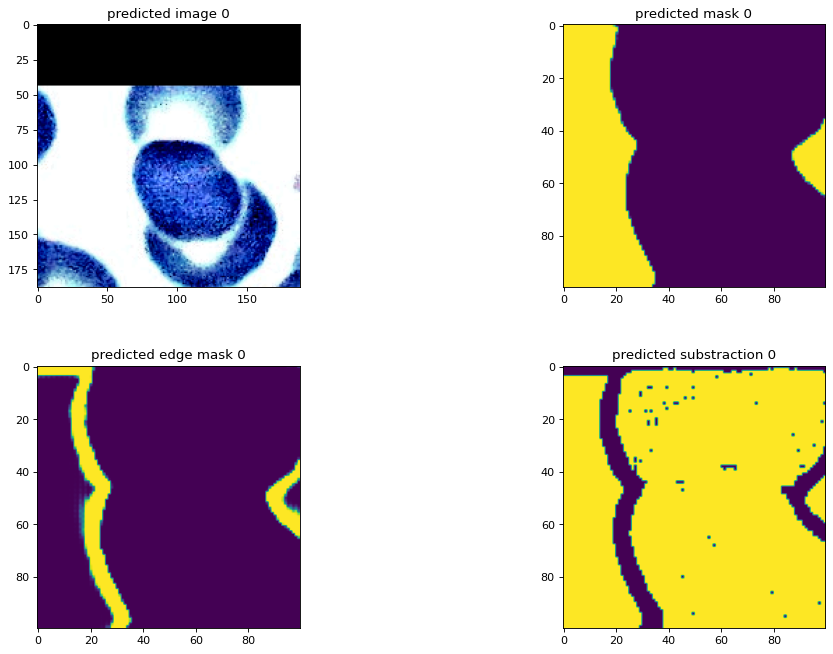

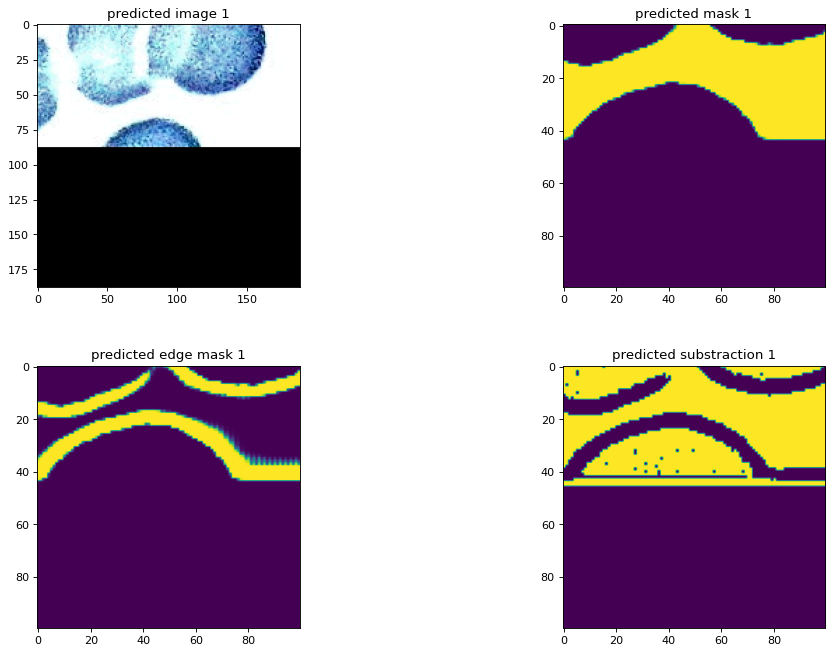

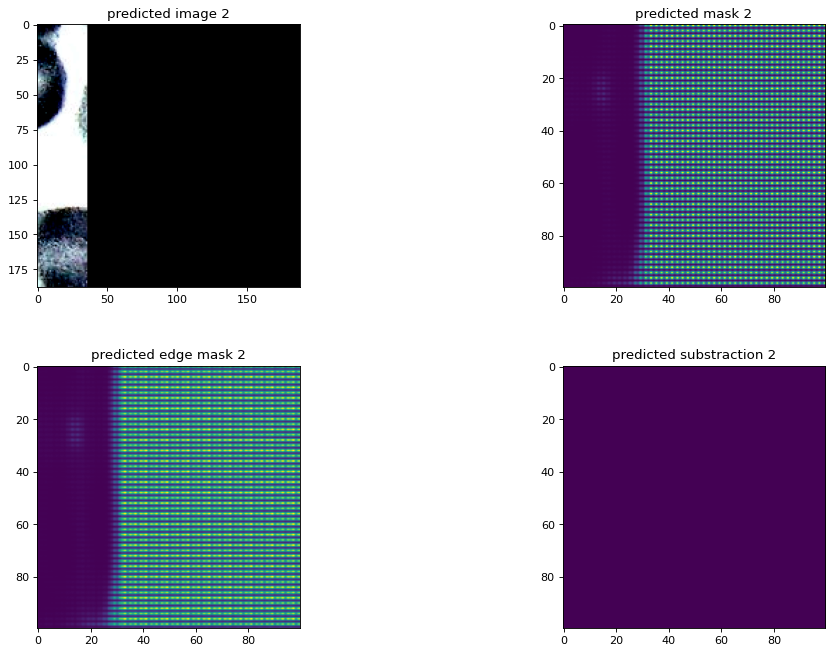

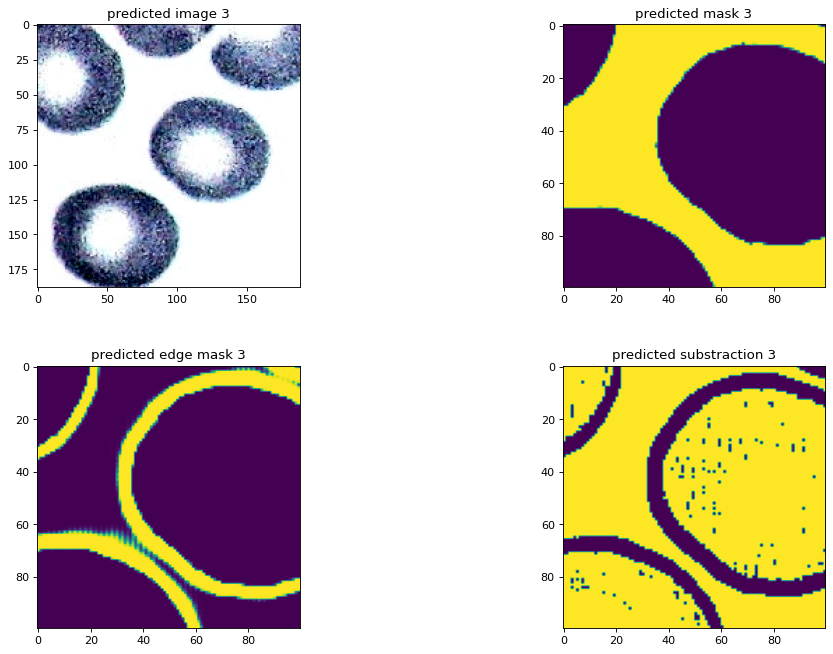

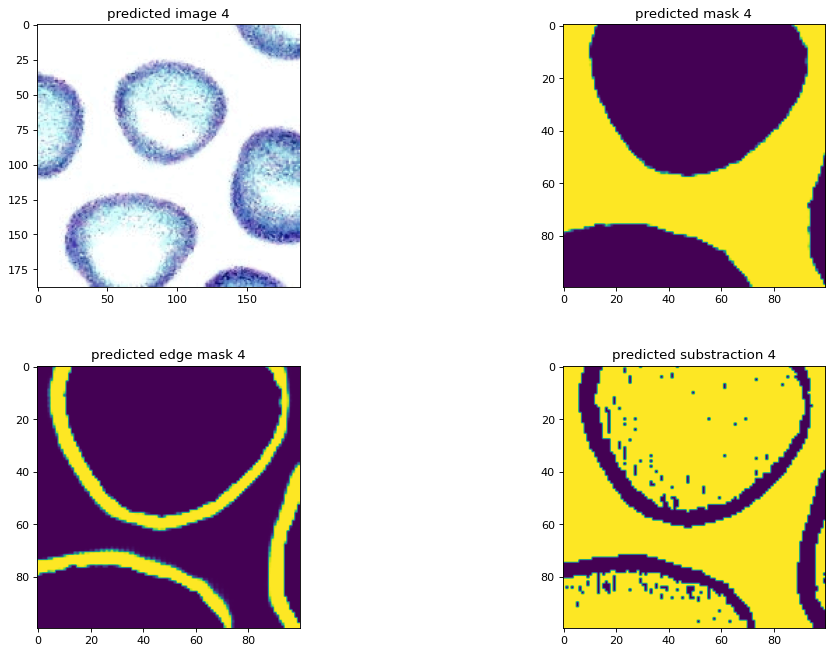

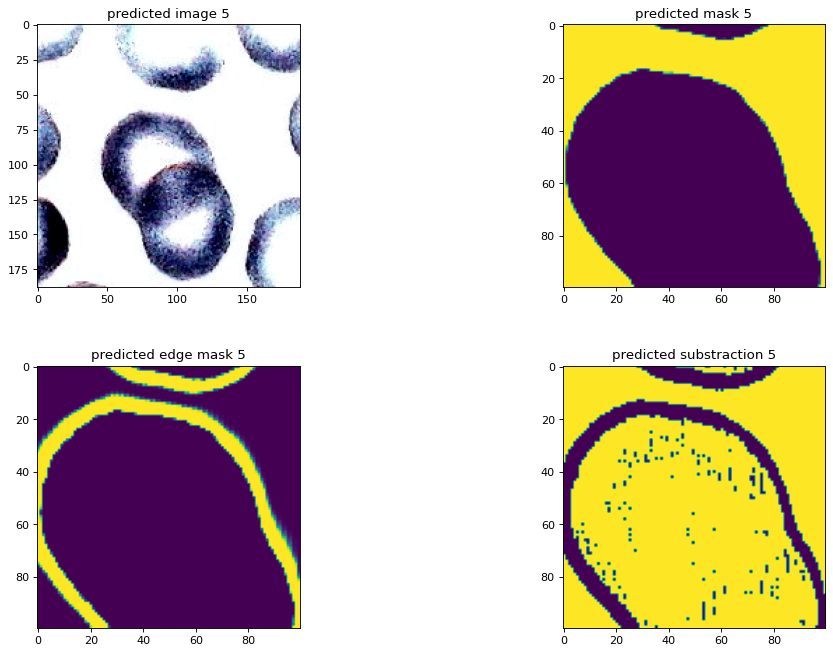

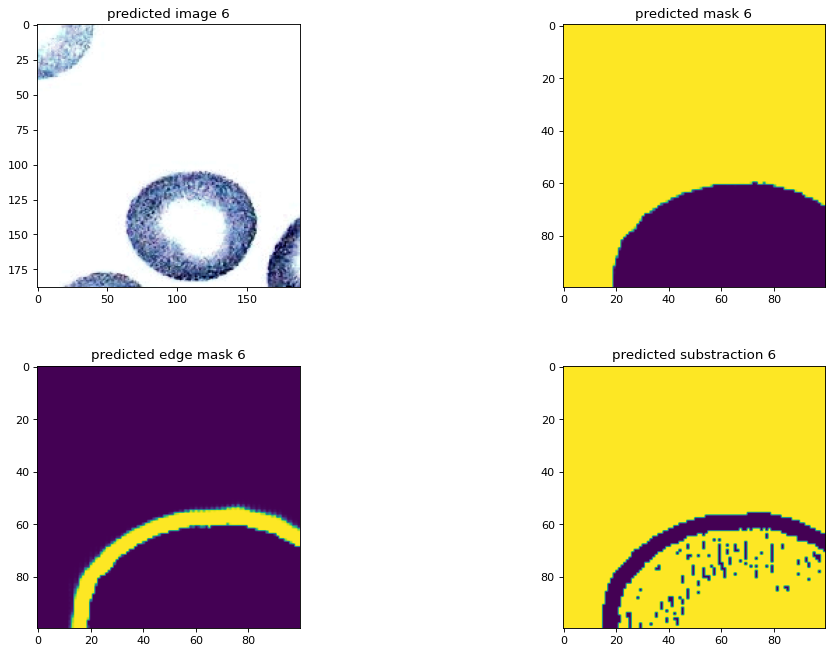

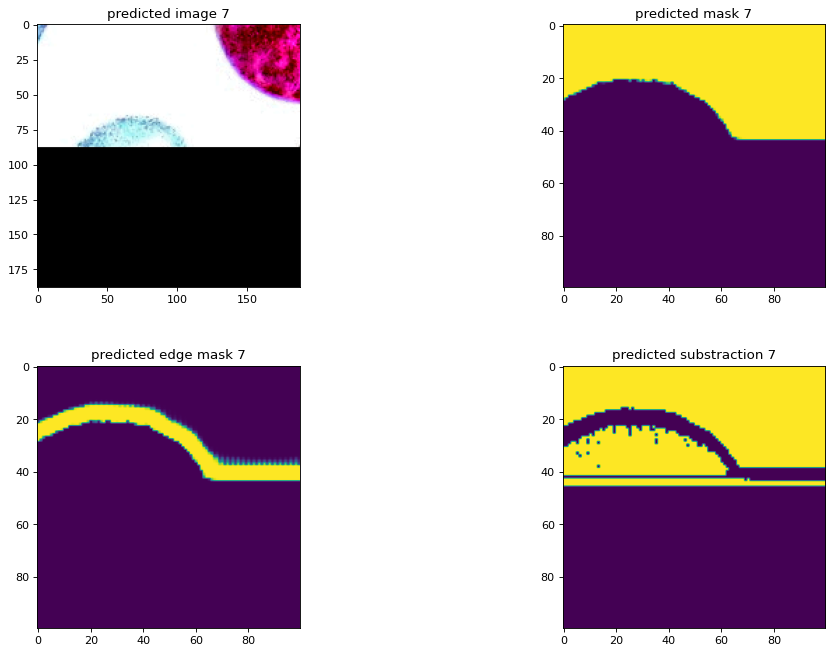

In [115]:

images, (masks, edges) = train_gen.__getitem__(1165)

#data.plot_ime(images, masks, edges)

prediction = unet.predict(images)

#prediction = np.squeeze(prediction)

data.plot_ime(images, prediction[0], prediction[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


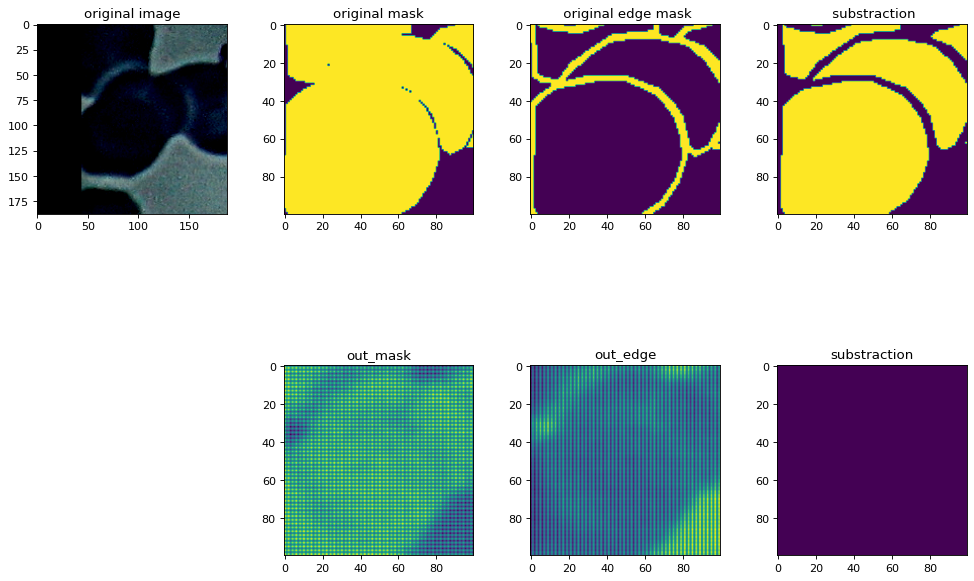

In [ ]:
fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original image")
ax.imshow(img[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original mask")
ax.imshow(mask)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" original edge mask")
ax.imshow(edge)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" substraction")
ax.imshow((mask - edge) > 0)


fig_num = fig_num + 2
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_mask")
ax.imshow(prediction[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_edge")
ax.imshow(prediction[1])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("substraction")
ax.imshow((prediction[0] - prediction[1]) > 0)




- predict full image

In [ ]:
images, masks, edges = model.predictFullImage(unet,
                          data.load_data_na(test_img_files),
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)

In [ ]:
data.plot_ime(images,
              masks,
              edges,
              figSize=(25,15))

## model training data plot

In [ ]:
hist = history.history

lines = 4
columns = 3

fig = plt.figure(figsize=(20, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask accuracy")
ax.plot(hist['mask_acc'], label="Training")
ax.plot(hist['val_mask_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge mask accuracy")
ax.plot(hist['edge_acc'], label="Training")
ax.plot(hist['val_edge_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 2
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask loss")
ax.plot(hist['mask_loss'], label="Training")
ax.plot(hist['val_mask_loss'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge loss")
ax.plot(hist['edge_loss'], label="Training")
ax.plot(hist['val_edge_loss'], label="Validation")
ax.legend()

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("global loss")
ax.plot(hist['loss'], label="Training")
ax.plot(hist['val_loss'], label="Validation")
ax.legend()


fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask metrics")
ax.plot(hist['mask_dsc'], label="dsc")
ax.plot(hist['mask_mean_iou'], label="mean iou")
ax.plot(hist['mask_tversky'], label="tversky")
ax.plot(hist['mask_acc'], label="accuracy")

ax.set_title("mask metrics")
ax.plot(hist['val_mask_dsc'], label="val_dsc")
ax.plot(hist['val_mask_mean_iou'], label="val_mean iou")
ax.plot(hist['val_mask_tversky'], label="val_tversky")
ax.plot(hist['val_mask_acc'], label="val_accuracy")

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge metrics")
ax.plot(hist['edge_dsc'], label="dsc")
ax.plot(hist['edge_mean_iou'], label="mean iou")
ax.plot(hist['edge_tversky'], label="tversky")
ax.plot(hist['edge_acc'], label="accuracy")

ax.set_title("edge metrics")
ax.plot(hist['val_edge_dsc'], label="val_dsc")
ax.plot(hist['val_edge_mean_iou'], label="val_mean iou")
ax.plot(hist['val_edge_tversky'], label="val_tversky")
ax.plot(hist['val_edge_acc'], label="val_accuracy")
ax.legend()

## For Debugging
- show in between layers output

In [17]:
ind = np.random.randint(0, 32, 1)[0]

_pool1 = pool1[:-1,:-1,ind]
_pool2 = pool2[:-1,:-1,ind]
_pool3 = pool3[:-1,:-1,ind]
_down4 = down4[:-1,:-1,ind]
_up1 = up1[:-1,:-1,ind]
_up2 = up2[:-1,:-1,ind]
_up3 = up3[:-1,:-1,ind]

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_mask")
ax.imshow(out_mask)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_edge")
ax.imshow(out_edge)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool1")
ax.imshow(_pool1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool2")
ax.imshow(_pool2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool3")
ax.imshow(_pool3)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("down4")
ax.imshow(_down4)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up1")
ax.imshow(_up1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up2")
ax.imshow(_up2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up3")
ax.imshow(_up3)

NameError: name 'pool1' is not defined

- function to plot and array of images of shape (width, height, n_images)

In [ ]:
def picshow(img, title):
    num = img.shape[2]
    imgs_per_line = 4
    ax = num//imgs_per_line + 1
    ay = imgs_per_line
    fig =plt.figure(figsize=(30, num//imgs_per_line * 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(1,num + 1):
        sub = fig.add_subplot(ax,ay,i)
        sub.set_title(f"{title} {i}")
        sub.imshow(img[:-1,:-1,i - 1])
    plt.show()
    



In [ ]:
picshow(pool1, 'pool1 ')
picshow(pool2, 'pool2 ')
picshow(pool3, 'pool3 ')
picshow(down4, 'down4 ')
picshow(up1, 'up1 ')
picshow(up2, 'up2 ')
picshow(up3, 'up3 ')